# Introduction
---
This notebook will investigate the trends found in reviews of the Facebook app on the Google Store from [this dataset](https://www.kaggle.com/datasets/bwandowando/facebook-app-google-store-reviews-31-countries) found on Kaggle (it has since been updated and is now significantly larger). The goal is to apply some NLP processes and use Machine Learning to be able to predict whether incoming reviews are positive or negative. We'll go through these sections:

- Exploratory Data Analysis
- Natural Language Processing
- Machine Learning
- Combining Models

We'll have a quick look at the key aspects of our data in the EDA section, enabling us to get a feel of the dataset and explore some basic insights. By using many of the NLP functions found in the NLTK library we'll standardize the bodies of text and look at some visuals to give us a better understanding of the trends in our data. Then we'll apply some Machine Learning techniques to predict the sentiment found in the dataset. Finally, we'll use an ensemble approach and combine our trained models to give us a deployment-ready function that can analyse sentiment and give use a numeric confidence estimate.

# Step 1: Exploratory Data Analysis
---

Let's start by loading in all the basic libraries and modules necessary and, of course, our dataset.

In [1]:
# Import all the necessary packages.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import pickle
import nltk
import os

In [2]:
# Load in our raw data.
df = pd.read_csv('FACEBOOK_REVIEWS.csv')

df

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp
0,0,baecdfaa-fdcf-4ec2-8795-f9e1d0885c3a,167801889669597203549,Om******hy,bad app,1,0,318.0.0.39.154,2021-05-19 20:00:27
1,1,12e913d6-105e-4f0c-bb22-4f6a0561cb18,318460545610239421517,Sa****************ol,Really really annoying app ... like if its not...,1,0,317.0.0.51.119,2021-05-19 20:00:29
2,2,7db12237-0f42-4ef7-873b-99495d575331,530587565711923101092,Ca*********04,Cunsurinimo,1,0,293.0.0.43.120,2021-05-19 20:00:29
3,3,6d48f3e8-54c4-417a-83c9-6b198ef7c516,413352731163292273792,Ar**************07,Bad experience,1,0,318.0.0.39.154,2021-05-19 20:00:30
4,4,c4430a84-d74b-4e24-8ed6-1e28110a355b,972610065867074567951,Ab***********kh,Totally pathetic experience too many ads and b...,1,0,308.0.0.42.118,2021-05-19 20:00:30
...,...,...,...,...,...,...,...,...,...
2994731,2994731,f01698fa-5056-4199-b88f-d294050062cb,272225995443346295413,Ji**********ur,eed Red; Red raCCC !duxiixiuz En do,1,0,440.0.0.31.105,2023-11-13 23:20:59
2994732,2994732,796fa280-6530-49dc-bc7d-f93ae086b31d,147368069644520083993,A Google user,Not been working all day and no update availab...,1,0,440.0.0.31.105,2023-11-13 23:21:20
2994733,2994733,b31e8e70-4e3b-419b-aa2f-a8a3f5a0bd05,257906640422320735099,Wa***********em,Absolute bias towards Israel,1,0,436.0.0.35.101,2023-11-13 23:21:26
2994734,2994734,a229e971-5a99-47c7-bf07-48ca9c8ed491,180604354313420497079,Na********ed,لا حريه ف التعبر,1,0,438.0.0.33.118,2023-11-13 23:21:31


^

This is a fairly large dataset, with almost 3 million reviews. There's a lot of columns which we don't need, in fact, since Natural Language Processing, as the name suggests, is about processing text, we only really need to keep the text (reviews in our case) and their rating.

Let's remove any entries with NULL values for the `review_text` column and drop all unneeded columns.

In [3]:
# Checking how many NULL reviews there were.
print(len(df[df['review_text'].isna()]), "lines were dropped.")

# Dropping the NULL values.
df = df.drop(list(df[df['review_text'].isna()].index)
             ,axis = 0)

# Dropping needless columns.
# Since we'll be focusing on the text itself.
df = df.drop(columns = ['Unnamed: 0','review_id', 'pseudo_author_id', \
                        'author_name','review_likes', 'author_app_version'])

450 lines were dropped.


In [4]:
# Checking the dataframe.
df.head()

,review_text,review_rating,review_timestamp
0,bad app,1,2021-05-19 20:00:27
1,Really really annoying app ... like if its not...,1,2021-05-19 20:00:29
2,Cunsurinimo,1,2021-05-19 20:00:29
3,Bad experience,1,2021-05-19 20:00:30
4,Totally pathetic experience too many ads and b...,1,2021-05-19 20:00:30


^

Looking better, but I think we can make it even easier to read by placing the timestamp as the index and converting it to datetime, of course.

In [5]:
# Getting rid of the long name.
df.rename(columns = {'review_timestamp': 't_stmp'}, inplace = True)

# Setting our new index.
df.set_index('t_stmp', drop =True, inplace = True)

# Converting index to datetime.
df.index = pd.to_datetime(df.index)
df.head()

,review_text,review_rating
t_stmp,,
2021-05-19 20:00:27,bad app,1
2021-05-19 20:00:29,Really really annoying app ... like if its not...,1
2021-05-19 20:00:29,Cunsurinimo,1
2021-05-19 20:00:30,Bad experience,1
2021-05-19 20:00:30,Totally pathetic experience too many ads and b...,1


^

Great, our dataframe looks a lot easier to handle now. 

Let's get a few basic observations about the data, like the amount of time it spans and the distribution of the ratings. 

In [6]:
# Finding the first day, last day and difference in days.  
first_day = df.index.min()
last_day =  df.index.max()
total_time = last_day - first_day

print(f'First day: {first_day}')
print(f'Last day:  {last_day}')
print(f'The data spans {total_time.days} days.\n')

# Finding what percent of the reviews have which rating.
print("-------")
print('Amount of ratings per "star", and the percent of total reviews.')
print('Ordered by the amount of ratings.')

perc = df['review_rating'].value_counts(normalize = True)
numb = df['review_rating'].value_counts()

for i in range(len(numb)):
    print(f'  {numb.index[i]} star: {numb.iloc[i]} ratings at {perc.iloc[i]*100:.2f}%')

First day: 2021-05-19 20:00:27
Last day:  2023-11-13 23:23:21
The data spans 908 days.

-------
Amount of ratings per "star", and the percent of total reviews.
Ordered by the amount of ratings.
  5 star: 1320954 ratings at 44.12%
  1 star: 1267112 ratings at 42.32%
  4 star: 164978 ratings at 5.51%
  3 star: 129400 ratings at 4.32%
  2 star: 111842 ratings at 3.74%


^

Ok, so our data spans about two and a half years, and the majority (86%) of the reviews are either 1 or 5 stars.

In order to get a better understanding of the data, this report will categorize the reviews into 'positive' and 'negative'. We'll use 5 and 4-star reviews as positive, and 1 and 2-star reviews as negative. Removing the 3-star reviews completely shouldn't reduce our dataset too much (only by 4%) and will help create a clearer distinction between positive and negative sentiment. This categorization simplifies the analysis by focusing on extreme opinions, allowing for a more straightforward interpretation of sentiments expressed in the reviews.

Let's get rid of the 3-star reviews and take a look at the lengths of the texts.

In [7]:
# Dropping all rows with 3 star ratings.
df = df.drop(list(df[df['review_rating'] == 3].index) ,axis = 0)

# Checking our work.
print(f'Remaining 3 star reviews: {len(df[df["review_rating"] == 3])}')

Remaining 3 star reviews: 0


In [8]:
# Adding a column to the dataframe with the character-count.
df['char_count'] = df['review_text'].str.len()

In [9]:
#Taking a look at minimum/ maximum lengths of reviews.
print('                   Min length')
print(df['char_count'].sort_values().head(3), '\n')
print('    ---------     ')
print('                    Max Lengths')
print(df['char_count'].sort_values().tail(3), '\n')

print(f'Mean length of review: {df["char_count"].mean():.2f} chars.')

                   Min length
t_stmp
2021-09-15 16:19:52    1
2023-11-08 21:43:31    1
2021-10-06 09:29:12    1
Name: char_count, dtype: int64 

    ---------     
                    Max Lengths
t_stmp
2021-10-23 17:16:48    1489
2021-08-01 12:58:54    1589
2021-05-29 18:31:47    2829
Name: char_count, dtype: int64 

Mean length of review: 37.63 chars.


^

Now that we've removed the 3-star reviews, it looks like our remaining reviews range from one character to almost 3 thousand! But the mean is only 37 characters, suggesting that the majority of the reviews are quite short. 

Let's make a quick histogram to plot this.

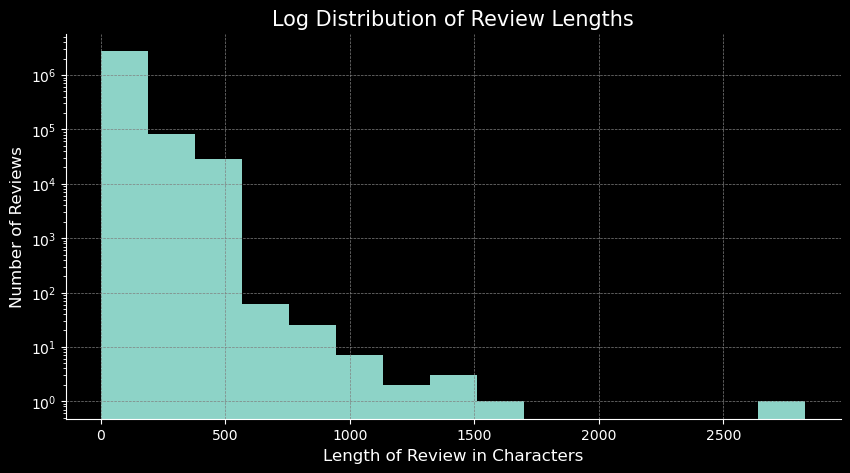

In [10]:
#Setting the dark styling.
plt.style.use('dark_background')

plt.figure(figsize=(10,5))
plt.hist(df['char_count'], log =True, bins = 15)

plt.title('Log Distribution of Review Lengths', size = 15)
plt.ylabel('Number of Reviews', size = 12)
plt.xlabel('Length of Review in Characters', size = 12)

#Getting rid of two boarders and making the gridlines look better. 
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

^

Notice here that a log-scale was used along the y-axis; since the data is *so* left-skewed that without using a log-scale all we can see is the first bin (from 0 to ~180).
Curiously, there's only 1 ($10^0$) value above 2000, and over 1,000,000 ($10^6$) values in the smallest bin. Looks as though people, in general, write shorter reviews.

Before moving on to the next step, let's create a new column which simply represents positive or negative comments.

In [11]:
# Creating a sentiment column, 'pos' or 'neg'.
df['sentiment'] = np.where(df['review_rating'] >= 4, 'pos', 'neg')

#let's have a quick look at our dataframe now.
df.head()

,review_text,review_rating,char_count,sentiment
t_stmp,,,,
2021-05-19 20:00:27,bad app,1,7,neg
2021-05-19 20:00:29,Really really annoying app ... like if its not...,1,163,neg
2021-05-19 20:00:29,Cunsurinimo,1,11,neg
2021-05-19 20:00:30,Bad experience,1,14,neg
2021-05-19 20:00:30,Totally pathetic experience too many ads and b...,1,157,neg


^

Great, we've prepared our dataset for Natural Language Processing. Before moving on, let's have a quick look at the distribution of negative and positive reviews.

In [12]:
df['sentiment'].value_counts(normalize = True)

sentiment
pos    0.518759
neg    0.481241
Name: proportion, dtype: float64

^

A fairly even split. 52% positive and 48% negative.

# Step 2: Natural Language Processing
---

In order to make our reviews a bit more useful, we're going to use a few of the tools found in Python's Natural Language Tool Kit (nltk), a module that provides a wide range of libraries and resources for natural language processing tasks. To each review, we will: 

1) **Tokenize**.

- This step involves breaking down the reviews into individual words or tokens.

2) **Remove 'stop words'**.
- Stop words are common words (e.g., "the", "and", "is") that are often removed in NLP tasks to focus on meaningful words.

3) **Remove punctuation**.
- This step involves eliminating punctuation marks from the text.

4) **Part of Speach (POS) tag the tokens**. 
- POS tagging involves assigning grammatical categories (such as noun, verb, adjective) to each token.

5) **Lemmatize**.
- Lemmatizing is the process of reducing words to their base or root form, often achieved by removing suffixes. For example, lemmatizing the word "running" would result in "run." This step helps standardize words to their essential form, facilitating more accurate analysis and interpretation in natural language processing tasks.

This simpler, more sentiment-rich text will provide us with more useful results.

Let's import all the necessary functions and packages, get our 'stop words', and define a function to apply to all of the corpora.

In [13]:
# Let's import most of the functions that we're
# going to use from NLTK.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

In [14]:
# Stop words are words which usually don't have a lot of value and get in the way.
# Let's use the set of stop words from NLTK.
stop_words = set(stopwords.words('english'))

#Adding a few extra words to the set.
wrd_lst = ["'s", "app", "account", "..", "...", "``", "''",
          "....", "u"]
for w in wrd_lst:
    stop_words.add(w)
    
    
print(stop_words)   

{'u', 'my', "aren't", 'is', 'here', 'for', 'herself', 'her', 'from', 'aren', 'mustn', 'few', 'shan', 'hasn', 'has', 'into', 'again', 'she', 'isn', 'than', 'needn', 'been', 'through', 'did', 'didn', "don't", 'all', 'his', 'under', 'each', 'off', 'he', 'only', 'any', 'but', 'the', 'won', 'out', 'so', 'll', 'who', 'being', 'more', "couldn't", "you'll", 'most', 'these', 'we', 'will', 'were', 'haven', 'am', 'that', "haven't", 'they', 'over', 'until', 'of', 's', 'd', 'then', 'wasn', 'own', 'which', 'while', 'above', "shouldn't", "mustn't", 'before', "didn't", 'mightn', 'app', "needn't", 'you', 'them', 'don', 'ain', "''", 'be', "it's", 'was', 'weren', 'yours', 'an', 'where', 'now', '``', 'up', 'what', 'do', 'both', 'wouldn', 'have', 'it', 'down', 'to', 'ma', "you'd", 'about', 'too', "you're", 'myself', "hasn't", "'s", 'on', 'had', 'i', "that'll", 'should', 'as', 'once', 'such', 'whom', 'couldn', 'their', 'other', 'me', 'when', 'him', 'yourself', 'hadn', 'in', 'its', 'against', 're', 'hers', '

In [15]:
# Our lemmatizing function below needs a supporting function.
# Because the POS tags used by nltk.pos_tag are different to those used
# by lemmatizer.lemmatize(), so when using these two functions, 
# we have to convert the tags.

#Defining a supporting function.
def penn_to_wordnet(pos_tag):
    if pos_tag.startswith('N'):
        return 'n'
    elif pos_tag.startswith('V'):
        return 'v'
    elif pos_tag.startswith('R'):
        return 'r'
    elif pos_tag.startswith('J'):
        return 'a'
    else:
        return 'n'

In [16]:
# Instantiating the lemmatizer.
lemmatizer = WordNetLemmatizer()

def lemmatize_body(text):
    '''
    Returns a lemmatized and more informationally 
    concentrated body of text from the input.
    
    text = string to lemmatize.
    '''
    #Double check that it's a string value.
    text = str(text).lower()
    
    #Tokenize the given text.
    tokens = nltk.word_tokenize(text)
    
    # Removing the stop words from the text.
    tokens_no_stop = [w for w in tokens if w not in stop_words]
    
    #Removing the punctuation.
    tokens_no_punc = [w for w in tokens_no_stop if w not in string.punctuation]
    
    #Adding the POS tags for each word.
    POS = nltk.pos_tag(tokens_no_punc)
    
    #The results will be a list of strings rather than one long string.
    results = []
    for word, pos in POS:
        wordnet_pos = penn_to_wordnet(pos)
        results.append(lemmatizer.lemmatize(word, pos = wordnet_pos))
        
    
    return results

In [17]:
# Importing swifter to try and speed up the application of the 
# function by parallelizing the process.
import swifter

In [18]:
# Applying our function to all 3 million reviews.
# Commenting this line out so we don't accidently
# run the code again. We'll pickle our results.
'''
df['lemmatized_text'] = df['review_text'].swifter.apply(lemmatize_body)
'''

"\ndf['lemmatized_text'] = df['review_text'].swifter.apply(lemmatize_body)\n"

In [19]:
# Saving our df at this point. 
'''
with open('df_with_lemmas.pkl', 'wb') as to_write:
    pickle.dump(df, to_write)
'''

"\nwith open('df_with_lemmas.pkl', 'wb') as to_write:\n    pickle.dump(df, to_write)\n"

In [20]:
# Re-opening the results.
with open('df_with_lemmas.pkl', 'rb') as to_read:
    df = pickle.load(to_read)

In [21]:
# Let's make a list of all of the words from all of the 
# lemmatized reviews.
all_words = []
for review in df['lemmatized_text']:
    for w in review:
        all_words.append(w)
        
all_words_dist = nltk.FreqDist(all_words)

^

Ok, after 17 minutes of computation, all 2.85 million reviews have now been simplified and have been semantically condensed.

We've also made an enormous list of all the words in all of the reviews.

Let's take a quick look at a random selection of 5 lines.

In [22]:
df[12345:12350]

,review_text,review_rating,char_count,sentiment,lemmatized_text
t_stmp,,,,,
2021-05-19 21:22:41,Racists,1,7,neg,[racist]
2021-05-19 21:22:41,very bad,1,8,neg,[bad]
2021-05-19 21:22:42,Bad experience,1,14,neg,"[bad, experience]"
2021-05-19 21:22:43,No Fairness,1,11,neg,[fairness]
2021-05-19 21:22:43,Jelek buangeeettttt,1,19,neg,"[jelek, buangeeettttt]"


^

Looks like the function worked.

Let's get a few visuals of our results and check the frequency distribution of all of our words.

In [23]:
#Let's have a look at the 20 most common words.
print(all_words_dist.most_common(20))

[('good', 374587), ('facebook', 299786), ('nice', 231810), ("n't", 181478), ('bad', 157514), ('bias', 88375), ('get', 80652), ('like', 80042), ('use', 75095), ('post', 73762), ('update', 65072), ('ca', 63557), ('please', 62837), ('time', 58439), ('love', 56537), ('fb', 56008), ('support', 55877), ('people', 53501), ('ad', 52904), ('best', 51215)]


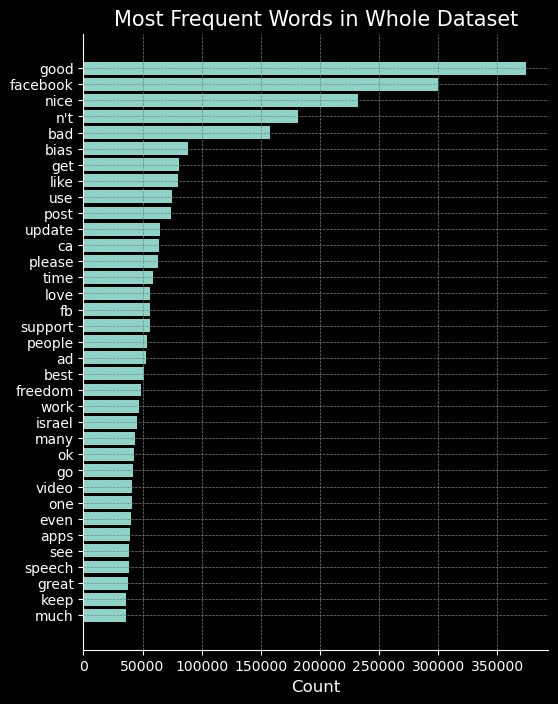

In [24]:
# Plotting a horizontal bar chart.
wrds = []
nums = []

for wrd, num in all_words_dist.most_common(35):
    wrds.append(wrd)
    nums.append(num)

# We need to reverse the results, or the largest results
# will be at the bottom. Counterintuitive...
wrds.reverse()
nums.reverse()

plt.figure(figsize=(6,8))
plt.barh(wrds, nums)

plt.title('Most Frequent Words in Whole Dataset', size = 15)
plt.xlabel('Count', size = 12)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

^

Ok, so this is a sense of what the most common words are in the whole dataset, no surprise in the top two words here: 'facebook' and 'good'. 'good', of course could be 'not good' but due to the way our function works, negations aren't handled for; the lemmatization process separates words into individual tokens, potentially losing the contextual meaning of phrases like 'not good.' In order to improve the accuracy of sentiment analysis, a more sophisticated approach would be needed to capture the nuances of negations and their impact on sentiment expressions. In future projects, a function could be defined to locate and join (using an underscore or hyphen) negations and their adjectives, but that's out of the scope of this report.

Let's get a more visually appealing view of the words in our full dataset using wordcloud.

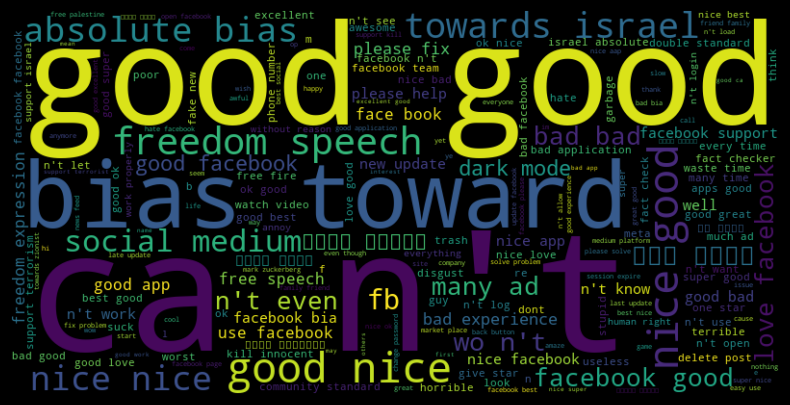

In [25]:
from wordcloud import WordCloud

# Creating one long string.
text = " ".join(all_words)

# Generating a word cloud image.
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

# Displaying the generated image.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

^

There are some interesting insights found within our visualization. It appears there's a wide variety of topics in our reviews. From simple expressions of sentiment like 'good', 'bad' and 'nice'. Moving toward user experience like 'dark mode', 'work properly' and 'new update', suggesting user's attention to the app's functionality. Additionally, the wordcloud even captures political issues like 'towards israel', 'freedom speech' and 'human right(s)'.

This highlights the reality that individuals often use platforms like Facebook to voice not only their personal experiences but also their socio-economic and political perspectives. It serves as an example of the platform's role as a forum for diverse conversations.

Let's see how the word trends change when we only look at the positive or negative reviews.

Starting with **positive** reviews.

In [26]:
# Getting the words for the positive group.
all_words_pos = []
for review in df['lemmatized_text'][df['sentiment']== 'pos']:
    for w in review:
        all_words_pos.append(w)
        
all_words_dist_pos = nltk.FreqDist(all_words_pos)

/Users/danielanderson/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


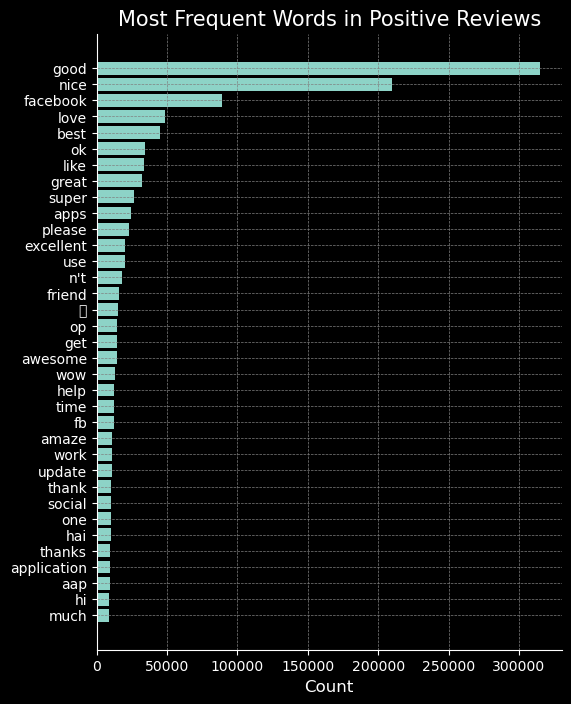

In [27]:
# Plotting the most common words in the positive reviews.
wrds = []
nums = []

for wrd, num in all_words_dist_pos.most_common(35):
    wrds.append(wrd)
    nums.append(num)

wrds.reverse()
nums.reverse()

plt.figure(figsize=(6,8))
plt.barh(wrds, nums)

plt.title('Most Frequent Words in Positive Reviews', size = 15)
plt.xlabel('Count', size = 12)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

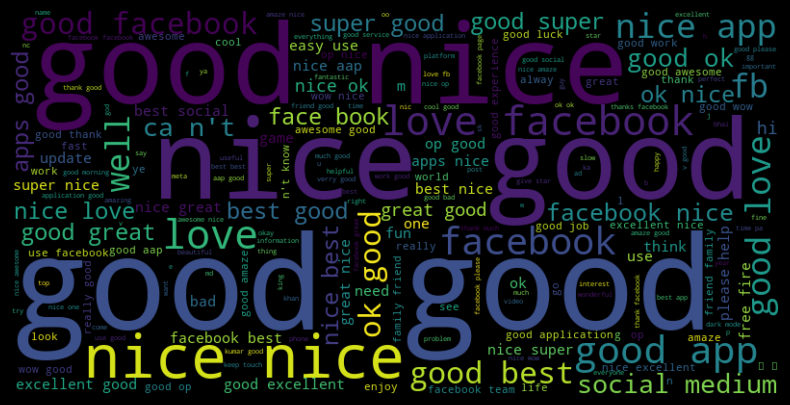

In [28]:
#Creating a positive review wordcloud.
text = " ".join(all_words_pos)

wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

^

The difference from the whole dataset is noticeable in the wordcloud above. Most of the words are in the positive spectrum, like: 'good', 'nice', 'love', 'super' etc.

Let's have a look at the **negative** reviews.

In [29]:
# Getting the words for the negative group.
all_words_neg = []
for review in df['lemmatized_text'][df['sentiment']== 'neg']:
    for w in review:
        all_words_neg.append(w)
        
all_words_dist_neg = nltk.FreqDist(all_words_neg)

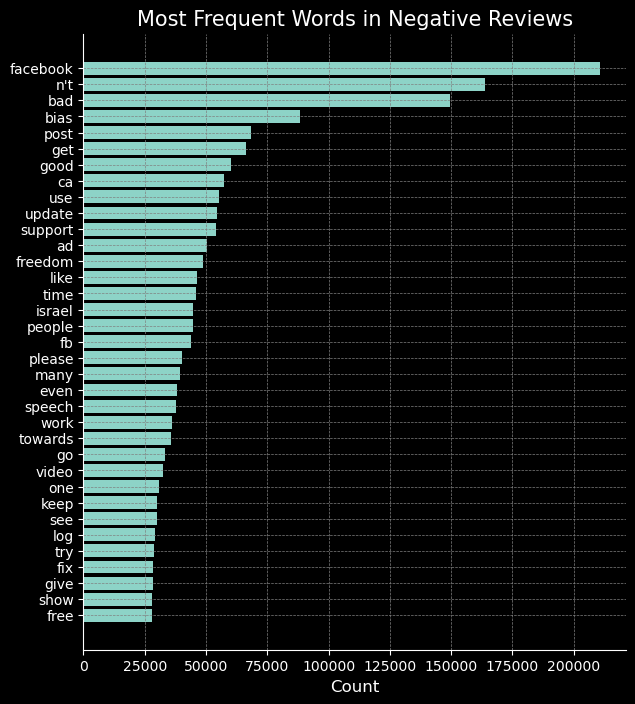

In [30]:
# Plotting the most common words in the negative reviews.
wrds = []
nums = []

for wrd, num in all_words_dist_neg.most_common(35):
    wrds.append(wrd)
    nums.append(num)

wrds.reverse()
nums.reverse()

plt.figure(figsize=(7,8))
plt.barh(wrds, nums)

plt.title('Most Frequent Words in Negative Reviews', size = 15)
plt.xlabel('Count', size = 12)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

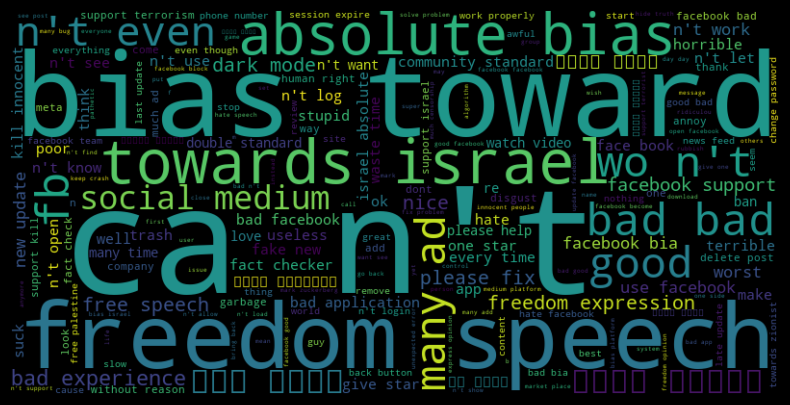

In [31]:
#Creating a negative review wordcloud.
text = " ".join(all_words_neg)

wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

^

A striking contrast from the positive reviews. The Google Store reviews are clearly an outlet for user's views on the role they believe Facebook plays in international political events. Where the positive reviews centered around simple expressions of sentiment like 'good', 'nice' etc... The negative reviews diverge from the Facebook app itself into its affiliations with political entities.

As of writing this analysis (the end of 2023), there's significant political unrest regarding the ongoing Israel / Palestine conflict. 

Curiously, 'good' also makes an appearance, likely preceded by some negation - 'not', 'isn't'. There **is** some user feedback regarding the application itself in examples like: 'dark mode', 'please fix' and 'late update', but this is clearly diminished by the personal political and ethical opinions that the users have in comparison to how they feel Facebook's affiliations lie. Additionally, the word 'facebook' appears more than twice as frequently in negative reviews as it does in positive ones, it seems as though if someone didn't like the facebook experience, they're more likely to 'call out' facebook.

# Step 3: Machine Learning
---

In this section, we will use the power of Machine Learning techniques to analyze the sentiment expressed in our dataset of Facebook app reviews. The primary objective is to build models capable of automatically categorizing reviews into positive or negative sentiments. By employing various Machine Learning algorithms, we aim to uncover patterns, features, and relationships within the text data that can be effectively used to predict the sentiment of unseen reviews. Through this exploration, we seek to gain insights into the effectiveness of different models and understand their potential for sentiment analysis in the context of user reviews on the Google Store.

We will:
- Use the 2000 most common words as our feature set.
- Define a function to format the review-label pair for use with NLTK.
- Select a reduced feature-set, since our data is extremely large.
- Split our data into train and test.
- Train five different models.
- Define a class which tells us how confident we are at categorizing a review.


In [32]:
# Importing the necessary packages. 
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier

In [33]:
# Let's use the 2000 most common words as our feature set.
# We'll essentially compare each review to the top 2000
# words, returning True if it contains the word and 
# False otherwise.

word_features = [word for word, num in all_words_dist.most_common(2000)]

In [34]:
# Creating list of tuples: (review, label), ready
# to have the following function applied to it.

review_label_pair = []

for rev, label in zip(df['lemmatized_text'], df['sentiment']):
    review_label_pair.append((rev,label))

In [35]:
def find_features(document):
    '''
    Use the set of words found in each review
    to define a dictionary which, out of the words
    found in word_features, tells us whether any of 
    those words are found in the review.
    
    e.g.
    {'good': True, 
     'facebook: True,
     'indoor': False,
     'swimming': False,
     ... }
     
     Where 'good', 'facebook' and 'swimming' are words 
     in word_features, and True/ False represent if that word
     exists in the review.
     
     document = body of text to compare to word_features.
    '''
    # We only need one of each word.
    words = set(document)
    
    # Instantiate the dictionary.
    features = {}
    
    #Check all of the words in word_features.
    for w in word_features:
        features[w] = (w in words)
        
    return features


In [36]:
# Let's randomize the reviews.
# We'll set a seed so each time we get the same results.

random.seed(42)
random.shuffle(review_label_pair)

In [37]:
# Our dataset is enormous, so let's just use 300,000 reviews.
# Since we randomized in the last cell, choosing the first
# 300,000 should be fair.
'''
featuresets = [(find_features(rev), label) for (rev, label) in review_label_pair[:300000]]
'''

'\nfeaturesets = [(find_features(rev), label) for (rev, label) in review_label_pair[:300000]]\n'

In [38]:
# Saving the featuresets in order to not run the cell again.
'''
with open('feature_set_1mil.pkl', 'wb') as to_write:
    pickle.dump(featuresets, to_write)
'''

"\nwith open('feature_set_1mil.pkl', 'wb') as to_write:\n    pickle.dump(featuresets, to_write)\n"

In [39]:
with open('feature_set_1mil.pkl', 'rb') as to_read:
    featuresets = pickle.load(to_read)

^

Great, now we have a set of 300,000 reviews, each with 2000 binary features for the Machine Learning algorithms to utilize in order to attempt to categorize the reviews. It's a shame to only use 10% of our dataset, but working locally, that's all that could be reasonably used, given computational constraints. For a large company who can implement distributed computing, using the full dataset would clearly be a better idea.   

Next, let's train on 200,000 of our randomly chosen reviews, and check the model's performance on the remaining 100,000.

Then we'll train and test the NLTK Naive Bayes Classifier, a simple algorithm that uses probabilistic principles to categorize text data into predefined classes. This classifier assumes that features are conditionally independent (that the words aren't related to each other), given the class, making it computationally efficient and well-suited for natural language processing tasks like sentiment analysis. We'll evaluate its performance on our preprocessed and lemmatized review data to assess its ability to distinguish between positive and negative sentiments.

In [40]:
# Splitting into train and test.
train = featuresets[:200000]
test = featuresets[200000:]

## Basic Naive Bayes

In [41]:
# Let's train a basic Naive Bayes Classifier.
# Commenting it out to not run it again.
# Let's pickle the file instead.
'''
clf = nltk.NaiveBayesClassifier.train(train)
'''

'\nclf = nltk.NaiveBayesClassifier.train(train)\n'

In [42]:
'''
with open('clf_NB.pkl', 'wb') as to_write:
    pickle.dump(clf, to_write)
'''    

"\nwith open('clf_NB.pkl', 'wb') as to_write:\n    pickle.dump(clf, to_write)\n"

In [43]:
with open('clf_NB.pkl', 'rb') as to_read:
    clf = pickle.load(to_read)

In [44]:
# Checking the accuracy.

print('Accuracy', (nltk.classify.accuracy(clf, test))*100)

Accuracy 79.14999999999999


In [45]:
# Checking which features were the 'most important'.
clf.show_most_informative_features(15)

Most Informative Features
                    حرية = True              neg : pos    =   1053.3 : 1.0
                   تعبير = True              neg : pos    =    710.4 : 1.0
             palestinian = True              neg : pos    =    692.5 : 1.0
               palestine = True              neg : pos    =    678.5 : 1.0
                     ليس = True              neg : pos    =    606.9 : 1.0
                    هناك = True              neg : pos    =    576.8 : 1.0
                    bias = True              neg : pos    =    386.0 : 1.0
              censorship = True              neg : pos    =    345.5 : 1.0
                  censor = True              neg : pos    =    323.0 : 1.0
                  racist = True              neg : pos    =    308.7 : 1.0
                absolute = True              neg : pos    =    300.8 : 1.0
                  israel = True              neg : pos    =    292.8 : 1.0
                 towards = True              neg : pos    =    240.8 : 1.0

^

Wow, these features are shocking. There's a lot of strong language, and 4 cases of Arabic in the top 15. The rough translations are: 'freedom', 'express', 'not' and 'there'; at least according to Google. The ratios of negative to positive reviews are also startling with the top six words all appearing in at least 500 times more negative reviews than positive ones.

An accuracy of around 80% is quite high, but considering how strong and meaningful the language seems to be in these reviews, it appears that our model is finding it fairly simple to predict.

Let's train the remaining 4 models.

## Bernoulli Naive Bayes

In [46]:
# Training the Bernoulli Naive Bayes.
'''
clf_bernoulliNB = SklearnClassifier(BernoulliNB())
clf_bernoulliNB.train(train)
'''

'\nclf_bernoulliNB = SklearnClassifier(BernoulliNB())\nclf_bernoulliNB.train(train)\n'

In [47]:
'''
with open('clf_NB_bernou.pkl', 'wb') as to_write:
    pickle.dump(clf_bernoulliNB, to_write)
'''

"\nwith open('clf_NB_bernou.pkl', 'wb') as to_write:\n    pickle.dump(clf_bernoulliNB, to_write)\n"

In [48]:
with open('clf_NB_bernou.pkl', 'rb') as to_read:
    clf_bernoulliNB = pickle.load(to_read)

In [49]:
print('Accuracy:', (nltk.classify.accuracy(clf_bernoulliNB, test))*100)

Accuracy: 79.08


## Logistic Regression

In [50]:
# Training the Logistic Regresion model.
'''
clf_log_reg = SklearnClassifier(LogisticRegression())
clf_log_reg.train(train)
'''

'\nclf_log_reg = SklearnClassifier(LogisticRegression())\nclf_log_reg.train(train)\n'

In [51]:
'''
with open('clf_log_reg.pkl', 'wb') as to_write:
    pickle.dump(clf_log_reg, to_write)
'''

"\nwith open('clf_log_reg.pkl', 'wb') as to_write:\n    pickle.dump(clf_log_reg, to_write)\n"

In [52]:
with open('clf_log_reg.pkl', 'rb') as to_read:
    clf_log_reg = pickle.load(to_read)

In [53]:
print('Accuracy:', (nltk.classify.accuracy(clf_log_reg, test))*100)

Accuracy: 83.562


## SGD Classifier

In [54]:
# Training the stochastic gradient descent classifier.
'''
clf_sgd = SklearnClassifier(SGDClassifier())
clf_sgd.train(train)
'''

'\nclf_sgd = SklearnClassifier(SGDClassifier())\nclf_sgd.train(train)\n'

In [55]:
'''
with open('clf_sgd.pkl', 'wb') as to_write:
    pickle.dump(clf_sgd, to_write)
'''

"\nwith open('clf_sgd.pkl', 'wb') as to_write:\n    pickle.dump(clf_sgd, to_write)\n"

In [56]:
with open('clf_sgd.pkl', 'rb') as to_read:
    clf_sgd = pickle.load(to_read)

In [57]:
print('Accuracy:', (nltk.classify.accuracy(clf_sgd, test))*100)

Accuracy: 82.45400000000001


## XGBoost Classifier

In [58]:
# Training the XGB classifier.
'''
clf_XGB = SklearnClassifier(XGBClassifier())
clf_XGB.train(train)
'''

'\nclf_XGB = SklearnClassifier(XGBClassifier())\nclf_XGB.train(train)\n'

In [59]:
'''
with open('clf_XGB.pkl', 'wb') as to_write:
    pickle.dump(clf_XGB, to_write)
'''

"\nwith open('clf_XGB.pkl', 'wb') as to_write:\n    pickle.dump(clf_XGB, to_write)\n"

In [60]:
with open('clf_XGB.pkl', 'rb') as to_read:
    clf_XGB = pickle.load(to_read)

In [61]:
print('Accuracy:', (nltk.classify.accuracy(clf_XGB, test))*100)

Accuracy: 81.625


^

Looking at the results of these five trained algorithms, we can see a clear average accuracy of around 80%. Each model is accurately predicting 4/5 reviews. Next, let's create a custom class using all five models to give ourselves a sense of confidence in our predictions.

# Step 4: Combining Models
---

In this step we're going to combine our models to give us a more solid prediction and allow us to see how confident we are of our predictions. We'll define a class with two methods, then we'll test on some unseen data. 

In [62]:
# First, let's import the ClassifierI class from NLTK
# which is used as a base to create custom classes.
from nltk.classify import ClassifierI

# And let's import 'mode' to save time in calculating the mode.
from statistics import mode

In [63]:
# Defining the class

class VoteClassifier(ClassifierI):
    """
    A custom ensemble classifier that combines the predictions 
    of multiple individual classifiers using a majority voting scheme.

    Parameters:
    *classifiers: Any number of trained classifier instances to be 
    included in the ensemble.

    Methods:
    - classify(features): Takes a set of features and returns the final 
    classification based on majority vote.
    - confidence(features): Calculates the confidence level of the 
    final classification.
    """
    def __init__(self, *classifiers):
        self._classifiers = classifiers
        #classifiers is a list of trained classifiers
        
    def classify(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        #features is a feature_set 
        # (dict_of_words_boolean, label)
        return mode(votes)
    
    def confidence(self, features):
        votes = []
        for c in self._classifiers:
            v = c.classify(features)
            votes.append(v)
        
        choice_votes = votes.count(mode(votes))
        conf = choice_votes / len(votes)
        return conf 

voted_clf = VoteClassifier(clf, clf_bernoulliNB, clf_log_reg, clf_sgd, clf_XGB) 

^

Let's see how our new classifier performs on our training data.

In [64]:
# Testing the accuracy of our vote-system classifier.
'''
voted_acc = nltk.classify.accuracy(voted_clf, test)


with open('voted_results.pkl', 'wb') as to_write:
    pickle.dump(voted_acc, to_write)
'''

"'\nvoted_acc = nltk.classify.accuracy(voted_clf, test)\n\n\nwith open('voted_results.pkl', 'wb') as to_write:\n    pickle.dump(voted_acc, to_write)\n"

In [65]:
with open('voted_results.pkl', 'rb') as to_read:
    voted_acc = pickle.load(to_read)

In [66]:
print(f'Voted accuracy: {voted_acc *100:.0f}%')

Voted accuracy: 83%


^

We can see from the lack of improvement from our five single models that our VoteClassifier itself doesn't predict any better than any one of the individual models above. This may be because the individual models within the VoteClassifier ensemble lack sufficient diversity, possibly making similar predictions on a given set of instances. Ensemble methods, like majority voting, thrive when their models bring varied perspectives and capture different aspects of the data. In this case, the similar accuracies of the individual models may be limiting improvement. To enhance the ensemble's performance, exploring diverse base models or employing techniques that introduce variability among the classifiers could be considered.

Next, let's take a quick look at how our ensemble-trained-classifier class can tell us the prediction and how confident it is of the results.

In [67]:
# Selecting 25 lemmatized reviews to test our class.
ex_docs = test[25:50]

for doc in ex_docs: 
    print(f'Classification: "{voted_clf.classify(doc[0])}". '\
          f'Confidence: {voted_clf.confidence(doc[0])*100:.0f}%')

Classification: "neg". Confidence: 60%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 60%
Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "neg". Confidence: 60%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 80%
Classification: "pos". Confidence: 100%
Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "neg". Confidence: 80%


In [68]:
# Taking a look at the reviews that the model wasn't
# 100% sure about.
print(review_label_pair[200025][0])
print(review_label_pair[200029][0])
print(review_label_pair[200037][0])
print(review_label_pair[200044][0])
print(review_label_pair[200049][0])

['low']
['worry', 'wonder', 'problem', 'best', 'thing', 'ever', 'happen']
['bad']
['use', 'natural', 'place', 'dissapointed']
['video', 'show']


^

Above, from these 25 lemmatized reviews, we can see that our voting classifier is 100% confident (which is to say that all five of it's constituent models **predict** the same thing) in all but five examples. The lemmatized reviews have been printed out for us to check directly above.

We can see that two of the reviews were only one word in length -  at least after the lemmatization process: 'low' and 'bad', both of which were predicted to be negative reviews by three out of five of our models (since each model contributes 20%). Given that the lemmatization process may have removed some of the negation words, it seems reasonable to be **less** confident of simplistic one-word reviews.

Additionally, looking at the second lemmatized review that was printed, we can see a mixture of emotive words: 'best' and 'wonder', but also 'worry' and 'problem'. Again, given the mixed message in this review, it seems rational to be less confident on the review's positive or negative sentiment.

Finally, let's define a function, using our class, which could be put into production.

In [69]:
def review_sentiment(review):
    '''
    This function takes in a raw review and 
    returns it's predicted sentimnet along with 
    a level of confidence.
    
    review = string-value review.
    '''
    # Double check the input is a string.
    review = str(review)
    
    # Lemmatize the text.
    review = lemmatize_body(review)
    
    review = find_features(review)
    
    print(f'Classification: "{voted_clf.classify(review)}". '\
          f'Confidence: {voted_clf.confidence(review)*100:.0f}%')

^

The above function takes a simple string review, lemmatizes it, finds the features and then makes a prediction on its sentiment.

Let's give it a few random examples from our entire corpus, and just for fun, let's write a few of our own to see the results.

In [70]:
# Let's get three random numbers from the entire corpus.
random_numbers = random.sample(range(1, len(df)), 3)

In [71]:
# Let's write a few of our own reviews.
rev1 = "This app sucks. It always crashes, and the interface is \
confusing. I hate it."

rev2 = "am not 2 shure ... but in the end i like"

rev3 = "Terrible experience! The latest update ruined everything. Glitches,\
slow loading, and too many ads. Deleting this garbage app."

In [72]:
# We'll also take three random reviews from the whole dataset
# using our randomly generated numbers.
rev4 = df.iloc[random_numbers[0]][0]

rev5 = df.iloc[random_numbers[1]][0]

rev6 = df.iloc[random_numbers[2]][0]

print("Review 4:", rev4)
print("Review 5:", rev5)
print("Review 6:", rev6)

Review 4: I love this its wonderful
Review 5: Absolute bias towards Israel
Review 6: Good


In [73]:
# Let's make a list of our random reviews and our
# hand-written ones.
review_list = [rev1, rev2, rev3, rev4, rev5, rev6]

# And we'll see what the function outputs:
for rev in review_list:  
    review_sentiment(rev)

Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 60%
Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 100%
Classification: "neg". Confidence: 100%
Classification: "pos". Confidence: 100%


^

These results look good. The vote-classifier is only 60% confident with the second review (`rev2`), predicting the positive category. Given that it starts off negative with "am not 2 shure" but results in "in the end i like", confirms that the positive allocation was correct, while the 60% confidence rating is also warranted, since most of the content in the text is negative or neutral.

Judging as a human, I'd say that all six predictions were correct.

# Summary
---

This report set out to use Python's Natural Language Took-Kit and NLP techniques to create a function, trained on Facebook app reviews found on the Google Store, which automatically tells us whether the review is negative or positive, and to what percent the model is confident of its predictions. Natural Language Processing is a powerful tool that allows machines to comprehend and interpret human language, enabling them to extract meaningful insights from vast amounts of textual data.

- In the **EDA** section we cleaned and correctly formatted our dataset, facilitating simpler and quicker analysis. We described the basic information of our dataset like the amount of time it spans and what percentage of reviews were what 'star rating'. We gained an understanding of the length of our reviews and finally we simplified the 'star rating' to either positive or negative by removing the 3-star reviews, which only took a small portion of the data, making sure that the proportion of positive to negative was close to 50/50.
- While processing our text (**NLP**), we defined a function which applied many of the pre-processing tasks typical of NLP; like tokenization, the removal of stop-words, the removal of punctuation, Part of Speach (POS) tagging to correctly categorize the tokens and lemmatization. Some extremely strong and emphatic language was found when looking at which words had high distributions within our dataset, strong evidence that the users of the Facebook app feel a deep connection between the perceived political affiliations of Facebook and current socio-political unrest.
- During the **Machine Learning** stage, we created a feature-set from the 2000 most popular words found in the dataset and wrote a function to apply that feature-set to each element of our testing and training data. A choice was made to only take one tenth of the available data to train/ test given local computational constraints. Five models were trained on the same data to see if different techniques learned different ways to distinguish between the sentiment found in the reviews.
- We defined our own voting-classifier using the five other classifiers to ascertain whether the combination of the five different algorithms would result in a more accurate prediction than any single one. The results were disappointing, suggesting that all five models learned similar ways to differentiate between positive and negative reviews. We wrote a function which can take in a raw string and output a classification and confidence level. From testing the output of our function using six previously unseen reviews and checking them ourselves we concluded that the function seems to perform well.

Without delving too deep into politics, it's evidenced here that Facebook users feel strongly and are willing to voice their opinions on app reviews as a means of expressing their sentiments and concerns of greater geo-political events. Looking at the top 15 words used to divide the sentiment in the data, found in Step 3, we can see that almost all the words carry socio-political tones; with differentiating-ratios in the 100s to one, indicating that the model is looking for politically heavy words in order to categorize the review.

The `review_sentiment()` function defined in Step 4 stands as an example of something that could be put into production in a live data-source. Where, as the reviews are submitted insights could be gained instantly, one such example is a live sentiment-trend graph, where given any point in the day and given the ever-changing global political climate, the trend of positivity could be analysed potentially helping decision-makers and stakeholders to make judgments.

For future improvement, it would be advisable to employ a distributed computing framework to be able to benefit from the full dataset (which is still growing), thus enabling the models to be trained on the whole data available, improving their ability to categorize correctly. Also, utilizing a larger set of models to add to the ensemble-model would further increase the accuracy and make the confidence levels more granular. Furthermore, using the time-series data to investigate how user sentiment changes over time could prove insightful. Finally, a more thorough investigation into the use of negation words and the tokenization process may prove invaluable, allowing the model to gain even deeper insight into the sentiment.

## Conclusion

In conclusion, this project - given local computational constraints - successfully showcased the power of Natural Language Processing techniques using commonly available Python packages. While the sentiment analysis function demonstrated promising performance and potential real-world application, the extensive socio-political undertones observed in user reviews highlight the need for nuanced approaches in understanding user sentiments. As the field of NLP continually evolves, future work should explore more advanced techniques, leverage distributed computing for larger datasets, and look deeper into linguistic negation and other nuances to improve the accuracy and depth of sentiment analysis potentially found in app reviews.